In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.plots import plots
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory, format_for_path
from toolkit.pipeline.signal import average_psd_across_sessions
from toolkit.paths import paths
from toolkit.plots.format import SAVE_FIGURE, save_figure

## Config

In [2]:
session_set = 'selected'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

Sessions missing from the data cache directory:
732592105
737581020
739448407
742951821
744228101
746083955
750332458
750749662
754312389
755434585
756029989
757216464
757970808
758798717
759883607
762120172
763673393
768515987
771990200
774875821
778240327
779839471
781842082
786091066
787025148
791319847
794812542
798911424
799864342
816200189
831882777
839068429
840012044
847657808


In [3]:
figsize = (3.6, 3.0)
plt_range = 100.  # PSD frequency range for plotting

condition_wave_band = GLOBAL_SETTINGS['condition_wave_band']

session_set_name = f'{session_set}_sessions'

## Load data

In [4]:
psd_dss = {}
cond_psd_das = {}
bands_dss = {}
preferred_orientations = {}

session_types = {s: [] for s in sessions_df['session_type'].unique()}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    # load PSD
    if not session_dir.exist:
        print(f"Failed to load PSD for session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Failed to load PSD for session {session_id}: no lfp data")
    else:
        session_type = sessions_df.loc[session_id, 'session_type']
        psd_dss[session_id] = session_dir.load_psd()[0]
        cond_psd_das[session_id] = session_dir.load_conditions_psd()
        bands_dss[session_id] = session_dir.load_wave_bands()
        preferred_orientations[session_id] = session_dir.load_preferred_orientations(condition_wave_band)
        session_types[session_type].append(session_id)

session_list = list(psd_dss)

In [5]:
fss = np.array([ds.attrs['fs'] for ds in psd_dss.values()])
fs = np.round(np.median(fss))  # round to integer sampling rate

# check if all sampling rates are the same
if np.any(np.round(fss) != fs):
    raise ValueError(f'Inconsistent sampling rate found.')

nfft = next(iter(psd_dss.values())).attrs['nfft']
# check if all nffts are the same
if any(ds.attrs['nfft'] != nfft for ds in psd_dss.values()):
    raise ValueError(f'Inconsistent nfft found.')

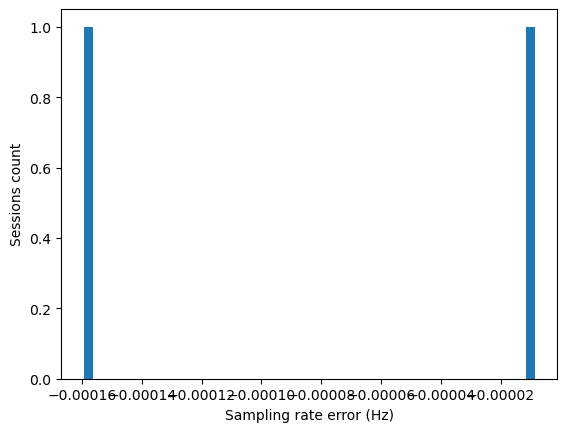

In [6]:
plt.hist(fss - fs, bins=50)
plt.xlabel('Sampling rate error (Hz)')
plt.ylabel('Sessions count')
plt.show()

## Analyze data

### Average PSD across sessions

In [7]:
psd_avg = {}
psd_ds = {}
cond_psd_ds = {}
cond_psd_avg = {}
bands_ds = {}

for session_type, session_ids in session_types.items():
    # average PSD across sessions
    psd_avg[session_type], psd_ds[session_type] = average_psd_across_sessions(
        (psd_dss[session_id] for session_id in session_ids), fs=fs, nfft=nfft
    )

    # average drifting gratings conditions PSD across sessions
    for stim in st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']:
        cond_psd_avg[stim], cond_psd_ds[stim] = average_psd_across_sessions(
            (cond_psd_das[session_id][stim] for session_id in session_ids), fs=fs, nfft=nfft
        )

    # combine bands of sessions
    bands_ds[session_type] = xr.concat(
        (bands_dss[session_id] for session_id in session_ids),
        data_vars=['bands', 'peaks', 'center_freq'],
        dim=pd.Index(session_ids, name='session_id')
    )

### FOOOF Analysis

#### Fooof parameters

In [8]:
ds = list(bands_ds.values())[0]
fooof_params = {k: ds.attrs[k] for k in [
    'freq_range', 'aperiodic_mode', 'peak_width_limits', 'max_n_peaks', 'dB_threshold', 'peak_threshold'
]}

wave_band_limit = ds.data_vars['wave_band_limit']
wave_band_width_limit = ds.data_vars['wave_band_width_limit']
freq_band_kwargs = {k: ds.attrs[k] for k in ['top_n_peaks', 'bandwidth_n_sigma']}

#### Fit FOOOF and get frequency bands

In [9]:
fooof_objs = {}
avg_bands_ds = {}

for session_type in session_types:
    fooof_objs[session_type], avg_bands_ds[session_type] = ps.fit_fooof_and_get_bands(
        psd_avg[session_type], fooof_params, freq_band_kwargs, wave_band_limit, wave_band_width_limit)

Knee location: 0.34 Hz


c:\Users\ziaochen\projects\neuroscience\Analyzing_Allen_Visual_Coding_Neuropixels_Dataset\toolkit\analysis\spectrum.py:149: UserWarning: Negative value of knee parameter occurred. Re-fit without knee parameter.
  warnings.warn("Negative value of knee parameter occurred. Re-fit without knee parameter.")


Knee location: 0.28 Hz


c:\Users\ziaochen\projects\neuroscience\Analyzing_Allen_Visual_Coding_Neuropixels_Dataset\toolkit\analysis\spectrum.py:149: UserWarning: Negative value of knee parameter occurred. Re-fit without knee parameter.
  warnings.warn("Negative value of knee parameter occurred. Re-fit without knee parameter.")


#### Get band power in drifting grating conditions

In [10]:
cond_band_power_das = {}
layer_bands_ds = {}
for stim, cond_psd in cond_psd_avg.items():
    session_type = st.STIMULUS_SESSION_TYPES[stim]
    cond_band_power_das[stim], layer_bands_ds[stim] = ps.layer_condition_band_power(
        cond_psd.sel(stimulus=stim), avg_bands_ds[session_type].bands.sel(stimulus=stim),
        wave_band_limit, st.FIXED_CONDITION_TYPES[session_type], condition_wave_band=condition_wave_band
    )

### Convert frequency bands to table

In [11]:
row_dims = ('session_id', 'layer')  # dimensions to stack along rows
col_dims = ('stimulus', 'wave_band')  # dimensions to stack along columns

# rename columns with property names
bound_coord = ['low frequency', 'high frequency']
center_frequency_coord = [f'center frequency {i + 1:d}' for i in range(freq_band_kwargs['top_n_peaks'])]
peak_height_coord = [f'peak height {i + 1:d}' for i in range(freq_band_kwargs['top_n_peaks'])]

bands_df = {}
for session_type, ds in bands_ds.items():
    # Extract properties and rename coordinates
    band_da = ds.bands.assign_coords(bound=bound_coord)
    band_da = band_da.stack(row=row_dims, col=(*col_dims, 'bound'))

    cf_da = ds.center_freq.assign_coords(peak_rank=center_frequency_coord)
    cf_da = cf_da.stack(row=row_dims, col=(*col_dims, 'peak_rank'))

    peaks_da = ds.peaks.assign_coords(peak_rank=peak_height_coord)
    peaks_da = peaks_da.stack(row=row_dims, col=(*col_dims, 'peak_rank'))

    # Combine properties into a single data array
    df = []
    for da in [band_da, cf_da, peaks_da]:  # keep only row and col coordinates
        coords = dict(row=da.coords['row'].values, col=da.coords['col'].values)
        df.append(da.drop_vars(ds.dims, errors='ignore').assign_coords(coords))
    df = xr.concat(df, dim='col')  # properties along col dimension

    # Create multi-index for 2D dataframe
    row_coord = pd.MultiIndex.from_tuples(df.coords['row'].values, names=row_dims)

    col_coord = np.array(tuple(df.coords['col'].values))  # as 2d array
    col_coord = pd.MultiIndex.from_product((
            list(dict.fromkeys(col_coord[:, 0])),
            list(dict.fromkeys(col_coord[:, 1])),
            bound_coord + center_frequency_coord + peak_height_coord
        ),
        names=(*col_dims, 'band')
    )

    # Convert to dataframe
    coords = dict(row=row_coord, col=col_coord)
    df = df.sel(col=col_coord.values).assign_coords(coords).to_pandas()
    bands_df[session_type] = df

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_columns', None):
    for session_type, df in bands_df.items():
        print(session_type)
        display(df)

brain_observatory_1.1


stimulus           spontaneous                                    \
wave_band                 beta                                     
band             low frequency high frequency center frequency 1   
session_id layer                                                   
721123822  1               NaN            NaN                NaN   
           2/3             NaN            NaN                NaN   
           4               NaN            NaN                NaN   
           5               NaN            NaN                NaN   
           6a            31.82          47.68              39.75   

stimulus                                                                       \
wave_band                                                               gamma   
band             center frequency 2 peak height 1 peak height 2 low frequency   
session_id layer                                                                
721123822  1                    NaN           NaN           NaN           NaN   
           2/3                  NaN           NaN           NaN         48.47   
           4                    NaN           NaN           NaN         33.16   
           5                    NaN           NaN           NaN         40.22   
           6a                   NaN          0.11           NaN         45.21   

stimulus                                                               \
wave_band                                                               
band             high frequency center frequency 1 center frequency 2   
session_id layer                                                        
721123822  1                NaN                NaN                NaN   
           2/3            62.44              55.46                NaN   
           4              62.48              55.92              42.66   
           5              65.42              52.82                NaN   
           6a             65.69              55.45                NaN   

stimulus                                                                   \
wave_band                                        LGN gamma                  
band             peak height 1 peak height 2 low frequency high frequency   
session_id layer                                                            
721123822  1               NaN           NaN           NaN            NaN   
           2/3            0.19           NaN           NaN            NaN   
           4              0.21          0.10           NaN            NaN   
           5              0.10           NaN           NaN            NaN   
           6a             0.19           NaN           NaN            NaN   

stimulus                                                              \
wave_band                                                              
band             center frequency 1 center frequency 2 peak height 1   
session_id layer                                                       
721123822  1                    NaN                NaN           NaN   
           2/3                  NaN                NaN           NaN   
           4                    NaN                NaN           NaN   
           5                    NaN                NaN           NaN   
           6a                   NaN                NaN           NaN   

stimulus                             flashes                 \
wave_band                               beta                  
band             peak height 2 low frequency high frequency   
session_id layer                                              
721123822  1               NaN           NaN            NaN   
           2/3             NaN         30.11          44.59   
           4               NaN         28.51          39.22   
           5               NaN         28.22          36.87   
           6a              NaN         29.14          38.59   

stimulus                                                              \
wave_band       

functional_connectivity


stimulus           spontaneous                                    \
wave_band                 beta                                     
band             low frequency high frequency center frequency 1   
session_id layer                                                   
766640955  1               NaN            NaN                NaN   
           2/3             NaN            NaN                NaN   
           4               NaN            NaN                NaN   
           5               NaN            NaN                NaN   
           6a              NaN            NaN                NaN   
           6b              NaN            NaN                NaN   

stimulus                                                                       \
wave_band                                                               gamma   
band             center frequency 2 peak height 1 peak height 2 low frequency   
session_id layer                                                                
766640955  1                    NaN           NaN           NaN           NaN   
           2/3                  NaN           NaN           NaN         53.30   
           4                    NaN           NaN           NaN           NaN   
           5                    NaN           NaN           NaN           NaN   
           6a                   NaN           NaN           NaN         38.79   
           6b                   NaN           NaN           NaN         37.95   

stimulus                                                               \
wave_band                                                               
band             high frequency center frequency 1 center frequency 2   
session_id layer                                                        
766640955  1                NaN                NaN                NaN   
           2/3            67.11              60.20                NaN   
           4                NaN                NaN                NaN   
           5                NaN                NaN                NaN   
           6a             81.74              66.31              48.29   
           6b             77.22              47.52              63.44   

stimulus                                                                   \
wave_band                                        LGN gamma                  
band             peak height 1 peak height 2 low frequency high frequency   
session_id layer                                                            
766640955  1               NaN           NaN         51.44          59.25   
           2/3            0.06           NaN         51.28          59.54   
           4               NaN           NaN         50.84          60.56   
           5               NaN           NaN         51.25          60.06   
           6a             0.14          0.12         51.98          59.28   
           6b             0.12          0.11         52.04          59.08   

stimulus                                                              \
wave_band                                                              
band             center frequency 1 center frequency 2 peak height 1   
session_id layer                                                       
766640955  1                  55.34                NaN          0.20   
           2/3                55.41                NaN          0.68   
           4                  55.70                NaN          0.90   
           5                  55.65                NaN          0.69   
           6a                 55.63                NaN          0.42   
           6b                 55.56                NaN          0.32   

stimulus                             flashes                 \
wave_band                               beta                  
band             peak height 2 low frequency high frequency   
session_id layer                                              
766640955  1               NaN   

### Determine sessions with good waves

In [13]:
layer_of_interest = GLOBAL_SETTINGS['layer_of_interest']

has_beta = {}
has_gamma = {}
has_lgn_gamma = {}
for session_type, band_ds in bands_ds.items():
    band_ds = band_ds.sel(layer=layer_of_interest)
    session_ids = band_ds.coords['session_id'].values

    for session_id in session_ids:
        ds = band_ds.sel(session_id=session_id)
        # check beta exists in drifting gratings
        stim = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings'][0]  # first drifting grating stimulus as primary
        beta_peak = ds.peaks.sel(stimulus=stim, wave_band='beta', peak_rank=0).item()
        has_beta[session_id] = not np.isnan(beta_peak)

        # check gamma exists and no LGN gamma in movies
        has_gamma[session_id] = False  # any stimulus has gamma
        has_lgn_gamma[session_id] = False  # any stimulus has LGN gamma
        for stim in st.STIMULUS_CATEGORIES[session_type]['natural_movies']:
            gamma_peak, lgn_gamma_peak = ds.peaks.sel(
                stimulus=stim, wave_band=['gamma', 'LGN gamma'], peak_rank=0).values
            has_gamma[session_id] = has_gamma[session_id] or not np.isnan(gamma_peak)
            has_lgn_gamma[session_id] = has_lgn_gamma[session_id] or not np.isnan(lgn_gamma_peak)
            

#### Update sessions_df

In [14]:
has_wave_df = pd.DataFrame.from_dict(dict(
    has_beta=has_beta, has_gamma=has_gamma, has_lgn_gamma=has_lgn_gamma), orient='columns')

has_wave_df['good_waves'] = has_wave_df['has_beta'] & has_wave_df['has_gamma'] & ~has_wave_df['has_lgn_gamma']
print(has_wave_df.value_counts())

if session_set == 'all':  # update only when session_set is all
    sessions_df = pd.merge(
        sessions_df[[col for col in sessions_df.columns if col not in has_wave_df.columns]],
        has_wave_df, left_index=True, right_index=True, how='left'
    )
    sessions_df['selected'] = sessions_df['selected'] & sessions_df['good_waves'].fillna(True)

has_beta  has_gamma  has_lgn_gamma  good_waves
True      True       False          True          2
dtype: int64


#### Get beta and gamma bands of interest for sessions with good waves

In [15]:
if session_set == 'all':  # only when session_set is all
    bands_of_interest = []
    for session_id in sessions_df.index[~sessions_df['good_waves'].isna() & sessions_df['good_waves']]:
        session_type = sessions_df.loc[session_id, 'session_type']
        ds = bands_ds[session_type].sel(session_id=session_id, layer=layer_of_interest)
        # beta band
        stim = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings'][0]
        beta_da = ds.bands.sel(wave_band='beta', stimulus=stim).drop_vars('stimulus')
        # gamma band
        stim = st.STIMULUS_CATEGORIES[session_type]['natural_movies']
        gamma_da = ps.get_band_with_highest_peak(ds.sel(stimulus=stim, wave_band='gamma')).drop_vars('stimulus')
        # combine beta and gamma bands
        bands_of_interest.append(xr.concat([beta_da, gamma_da], dim='wave_band'))
    bands_of_interest = xr.concat(bands_of_interest, dim='session_id')

### Save data

Wave band csv for all sessions 

In [16]:
for session_type, df in bands_df.items():
    df.to_csv(paths.RESULTS_DIR / f'wave_bands_{session_type}_{session_set_name}.csv', float_format='%.2f')

Wave band data for average PSD

In [17]:
data_dir = paths.PROCESSED_DATA_CACHE_DIR / ecephys_structure_acronym
data_dir.mkdir(parents=True, exist_ok=True)
for session_type in session_types:
    avg_bands_ds[session_type].to_netcdf(data_dir / f'avarage_wave_bands_{session_type}_{session_set_name}.nc')

Save updated sessions selection fiile

In [18]:
if session_set == 'all':
    sessions_df.to_csv(paths.RESULTS_DIR / "session_selection.csv")

Save bands of interest

In [19]:
if session_set == 'all':
    bands_of_interest.to_netcdf(paths.RESULTS_DIR / f'bands_of_interest.nc')

## Visualize PSDs

In [20]:
if SAVE_FIGURE:
    fig_dir = paths.FIGURE_DIR / f"Average_PSD_{session_set_name}"
    cond_psd_dir = fig_dir / f"condition_psd"
    cond_band_power_dir = fig_dir / f"condition_{condition_wave_band}_power"
    layer_psd_dir = fig_dir / "layer_psd"
    fooof_dir = fig_dir / "fooof"

    fig_dir.mkdir(parents=True, exist_ok=True)
    cond_psd_dir.mkdir(parents=True, exist_ok=True)
    cond_band_power_dir.mkdir(parents=True, exist_ok=True)
    layer_psd_dir.mkdir(parents=True, exist_ok=True)
    fooof_dir.mkdir(parents=True, exist_ok=True)

### Plot average PSD of drifting gratings conditions

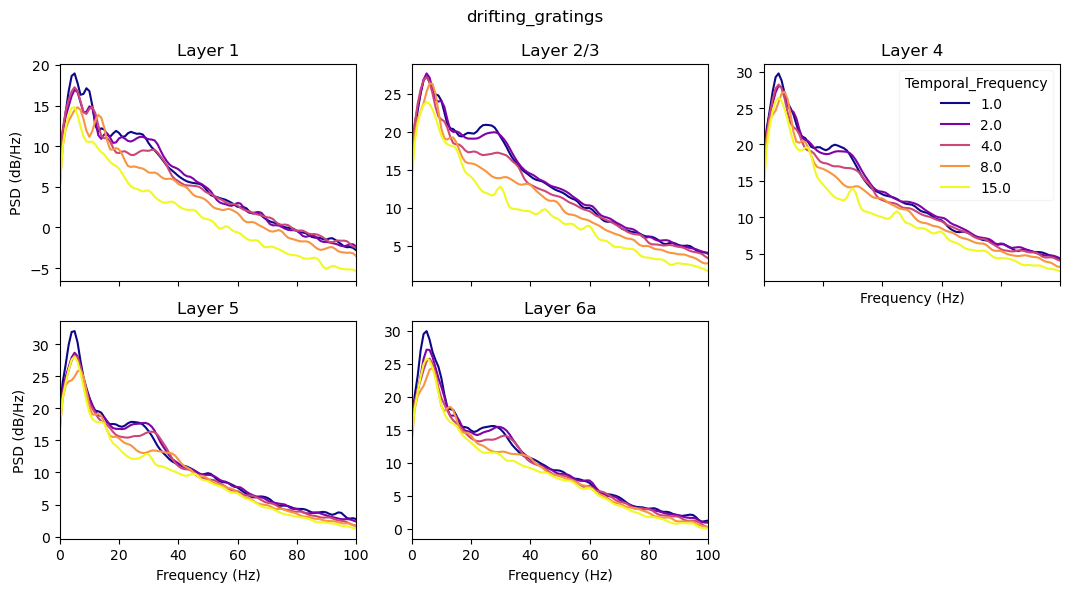

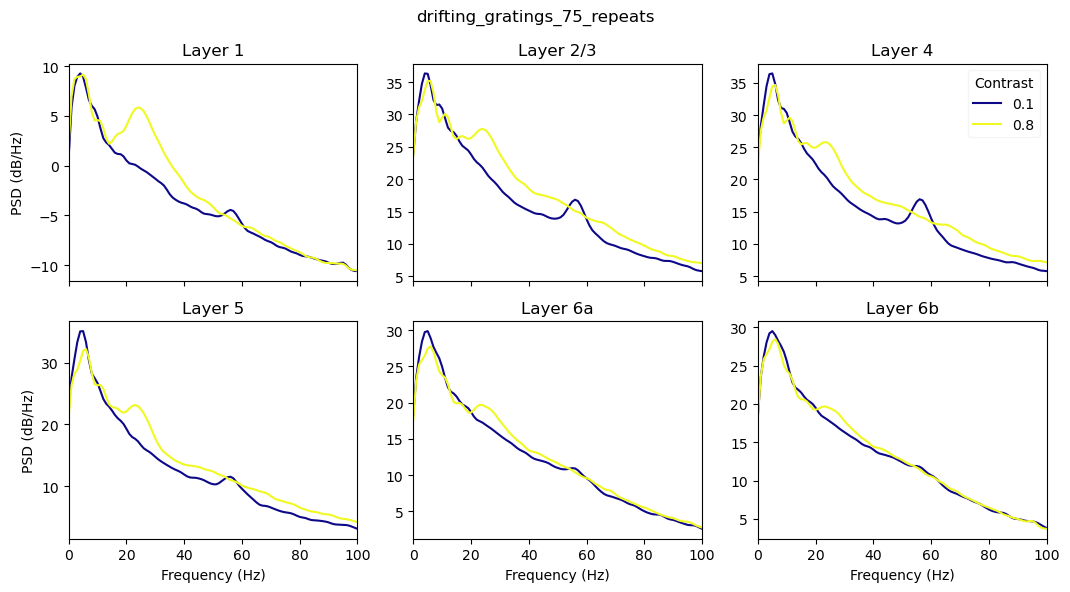

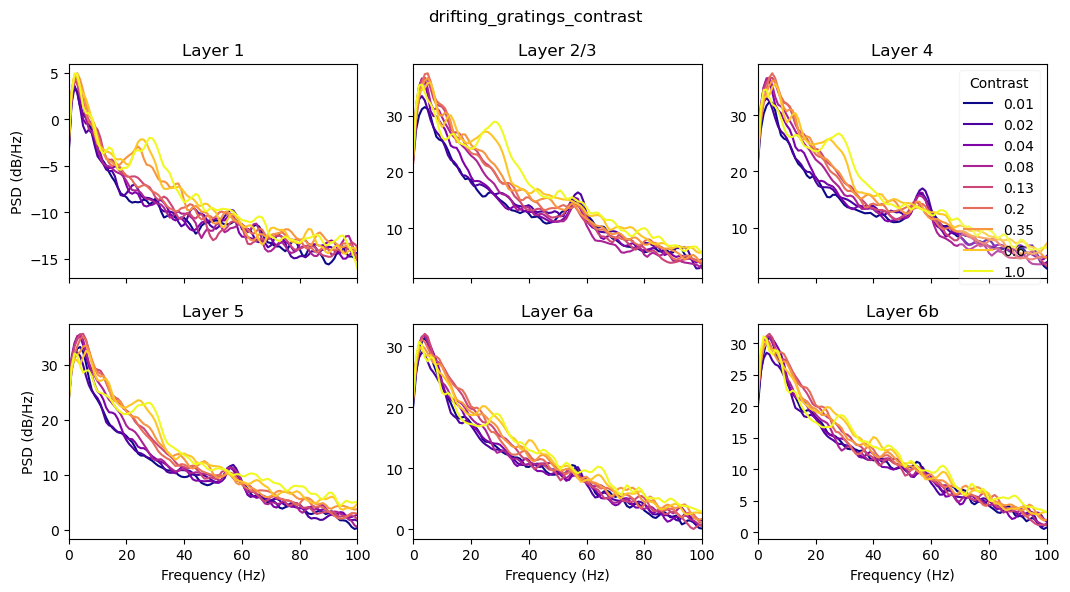

In [21]:
n_cols = 3
average_over = 'orientation'
condition_types = st.CONDITION_TYPES

for stim, da in cond_psd_avg.items():
    session_type = st.STIMULUS_SESSION_TYPES[stim]
    average_dims = st.FIXED_CONDITION_TYPES[session_type] + (average_over,)
    channel_dim = np.setdiff1d(condition_types, average_dims)[0]
    avg_da = da.mean(dim=average_dims)

    layers = avg_da.coords['layer'].values
    n_layers = len(layers)
    n_rows = np.ceil(n_layers / n_cols).astype(int)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_cols, figsize[1] * n_rows),
        sharex=True, squeeze=False)
    for i, layer in enumerate(layers):
        ax = axs.ravel()[i]
        layer_da = avg_da.sel(layer=layer, stimulus=stim)
        plots.plot_channel_psd(layer_da, channel_dim=channel_dim, freq_range=plt_range, ax=ax)
        ax.set_title(f'Layer {layer}')

    for ax in axs.ravel()[n_layers:]:
        ax.remove()
    for ax in axs.ravel()[:n_layers]:
        if ax is not axs[0, -1]:
            ax.get_legend().remove()
    for ax in axs[:, 1:].ravel():
        ax.set_ylabel('')
    for ax in axs.ravel()[:n_layers - n_cols]:
        ax.set_xlabel('')
    fig.suptitle(stim)
    fig.tight_layout()

    if SAVE_FIGURE:
        save_figure(cond_psd_dir, fig, name=stim)
    plt.show()

drifting_gratings


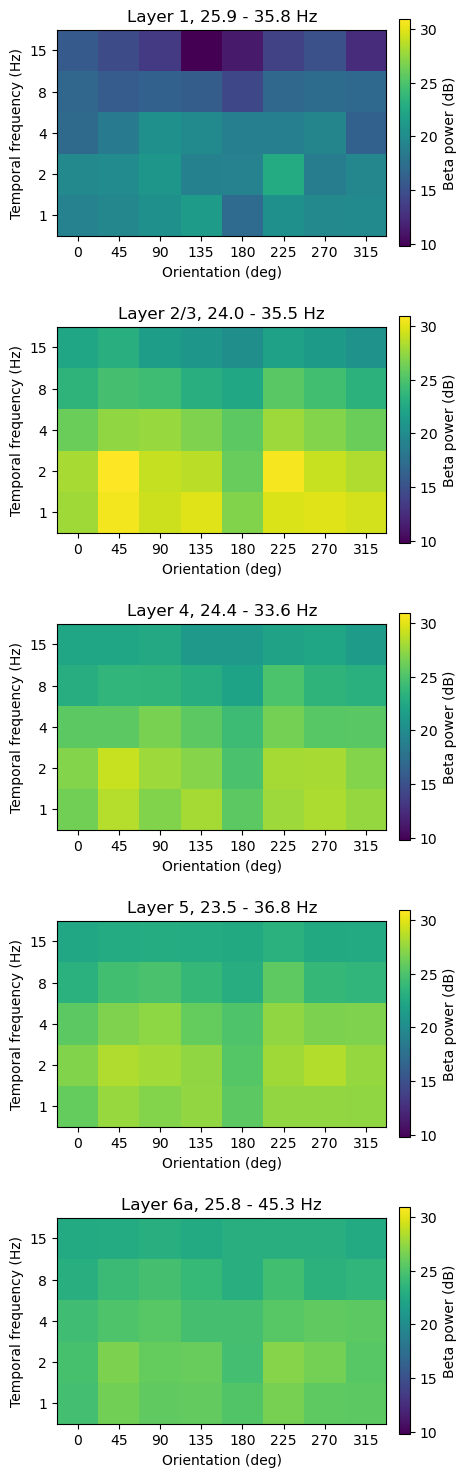

drifting_gratings_75_repeats


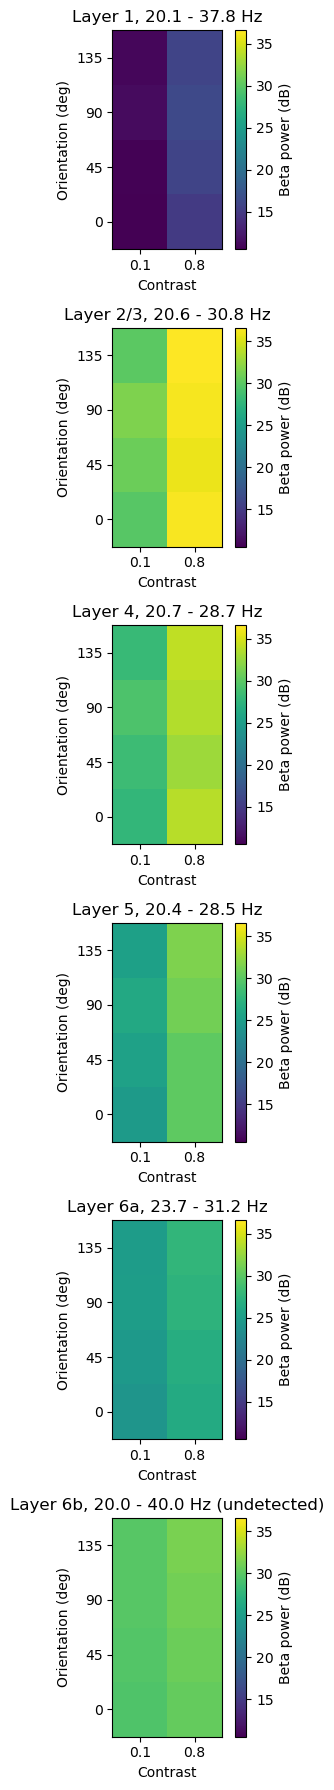

drifting_gratings_contrast


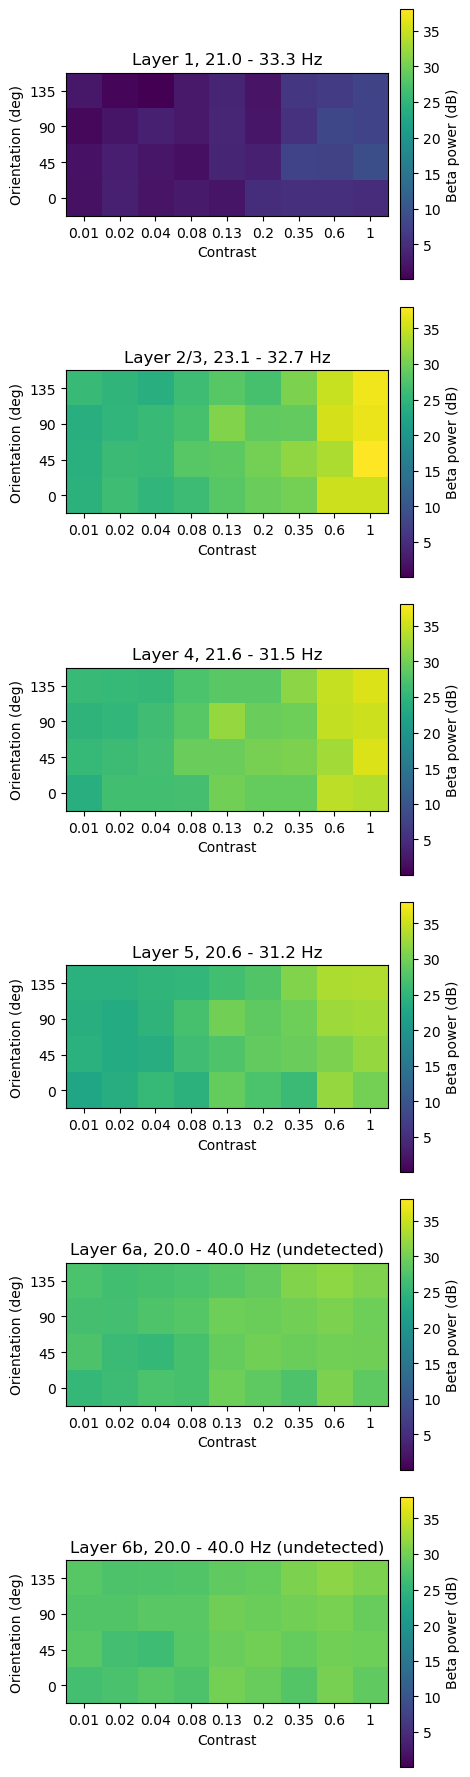

In [22]:
x_cond, y_cond = st.VARIED_CONDITION_TYPES[session_type]

for stim, cond_band_power in cond_band_power_das.items():
    print(stim)
    x_cond, y_cond = st.VARIED_CONDITION_TYPES[st.STIMULUS_SESSION_TYPES[stim]]
    fig, axs = plots.plot_layer_condition_band_power(cond_band_power, layer_bands_ds[stim], x_cond, y_cond)

    if SAVE_FIGURE:
        save_figure(cond_band_power_dir, fig, name=stim)
    plt.show()

### Plot average PSD of stimuli

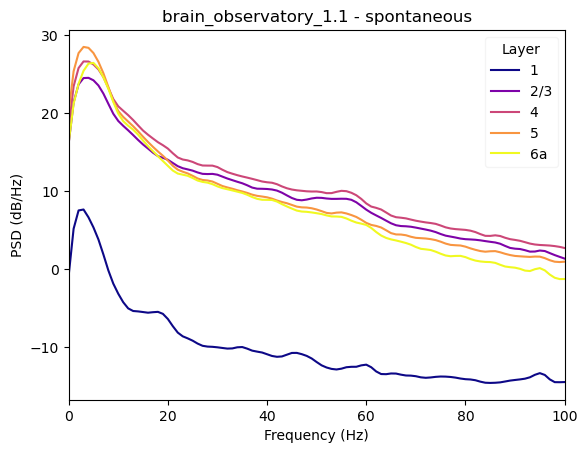

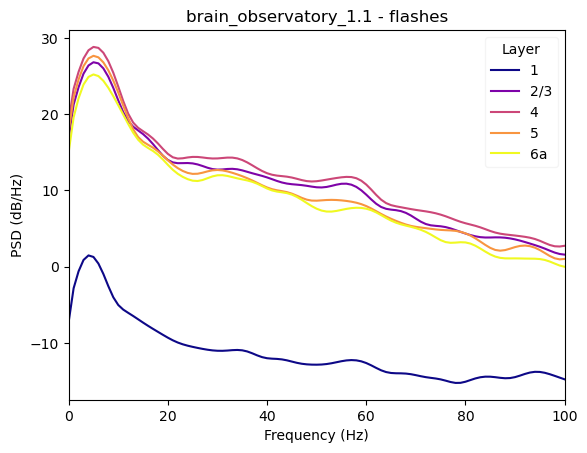

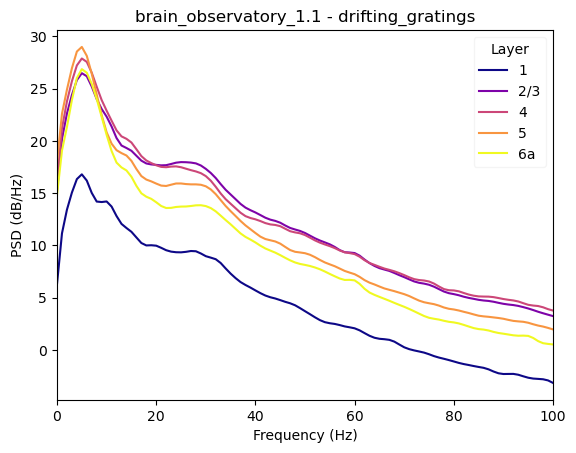

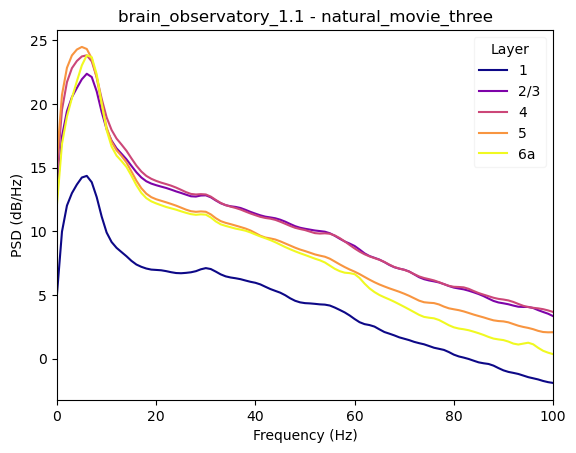

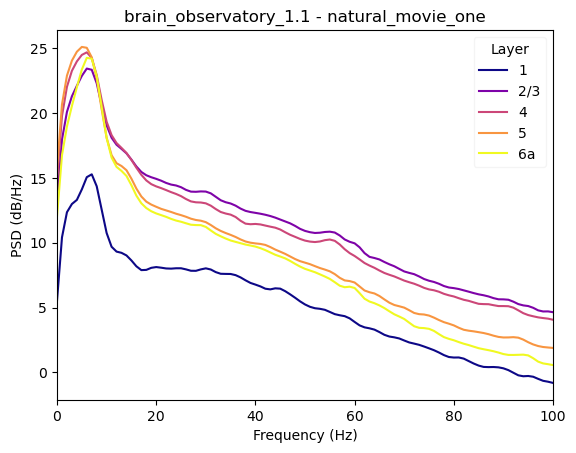

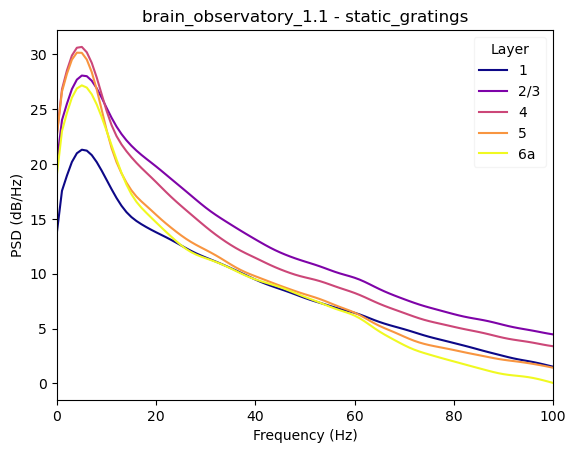

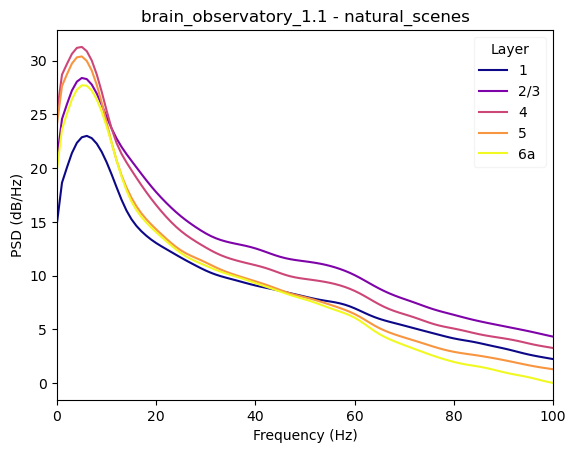

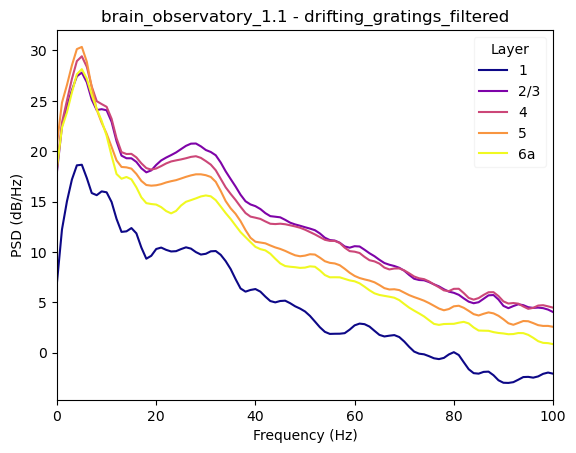

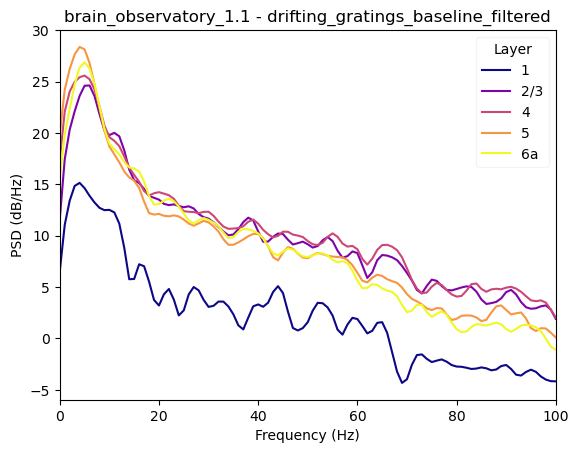

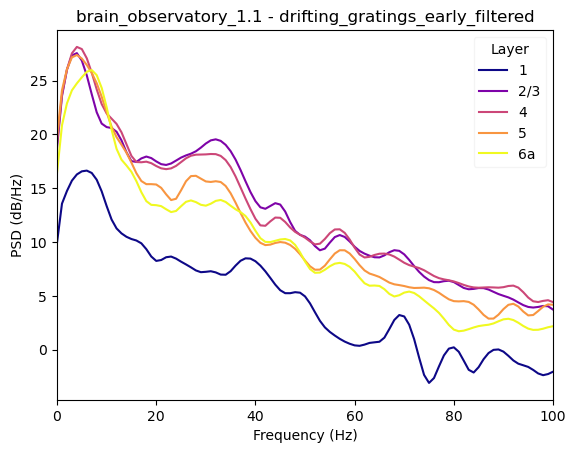

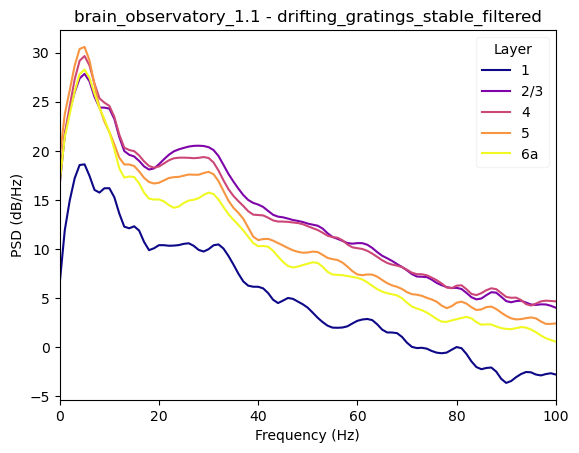

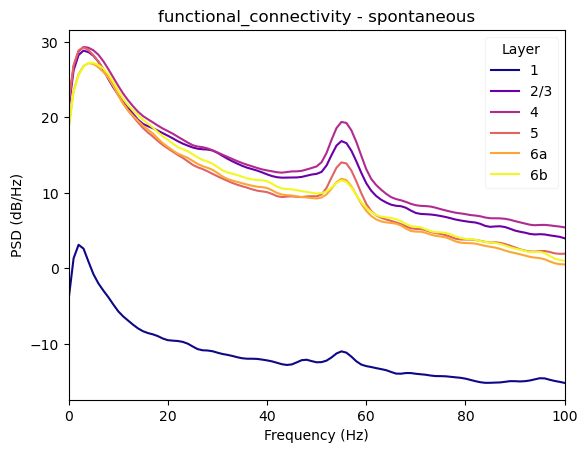

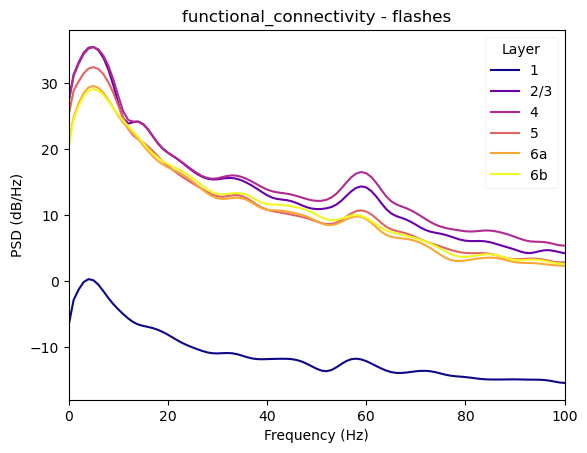

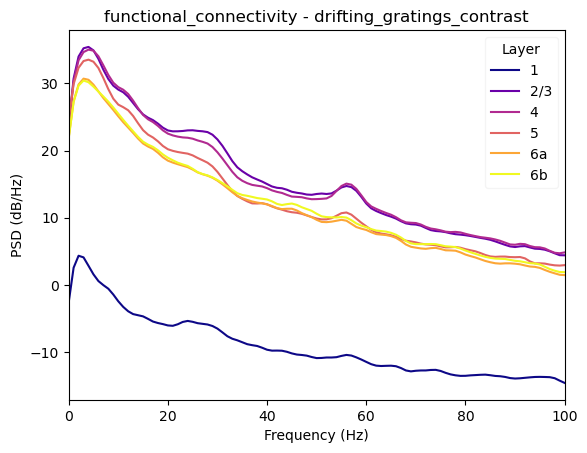

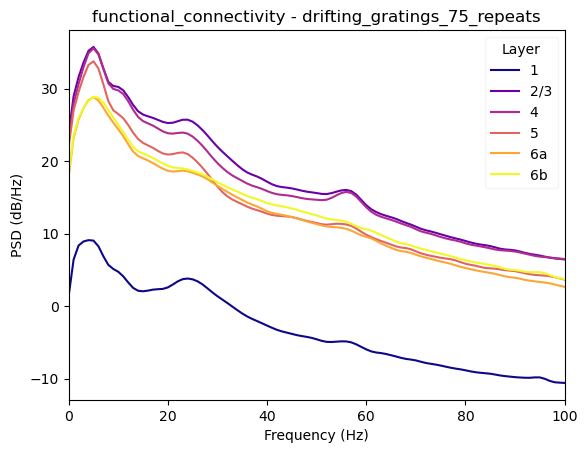

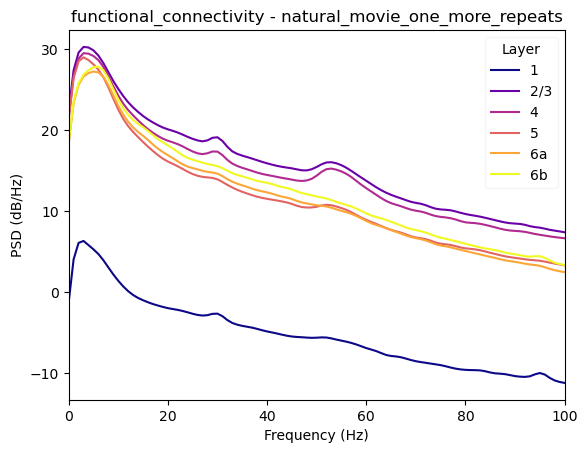

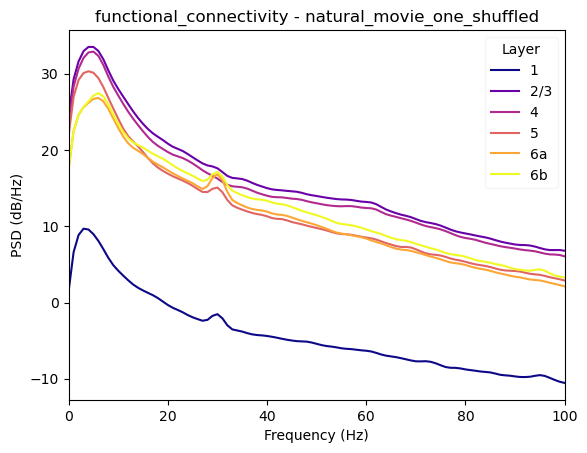

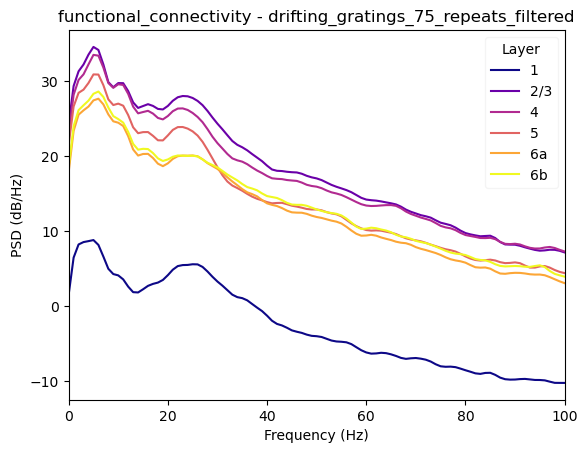

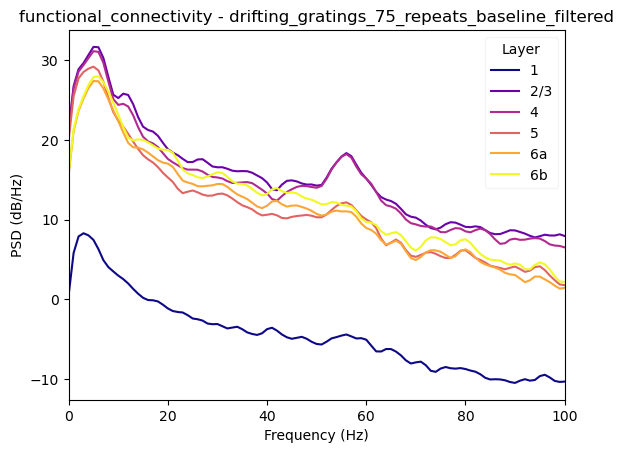

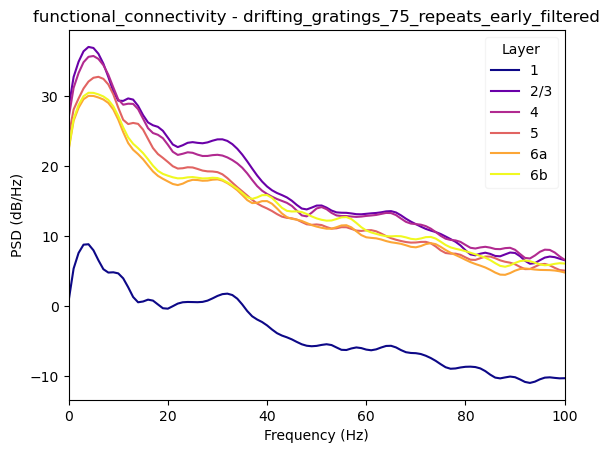

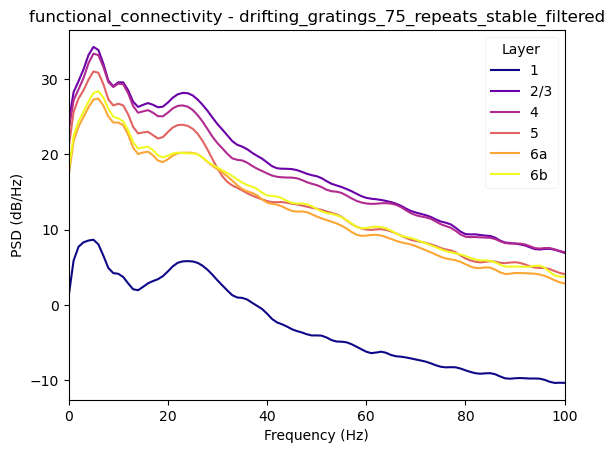

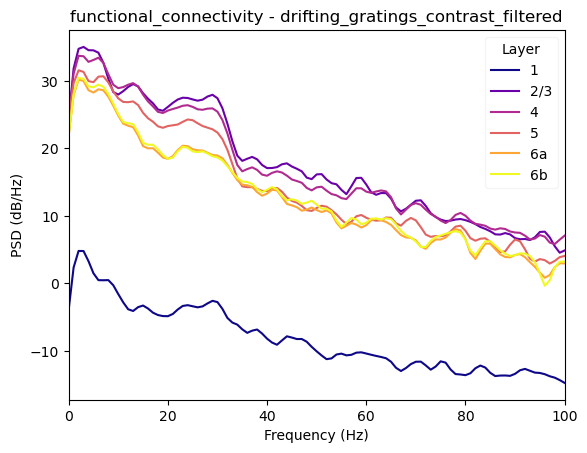

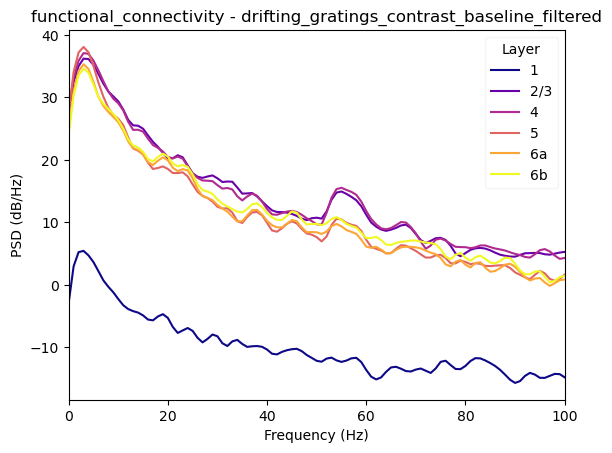

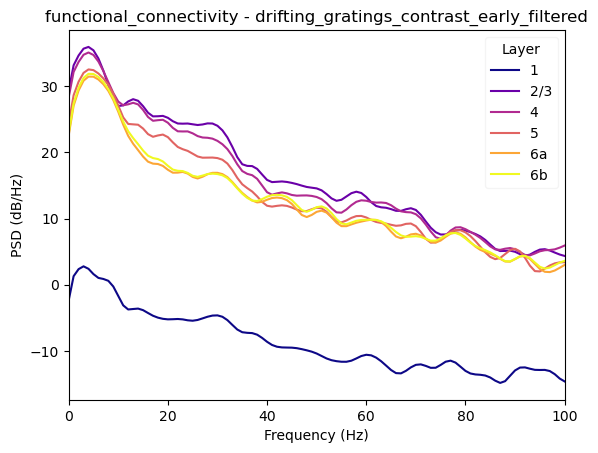

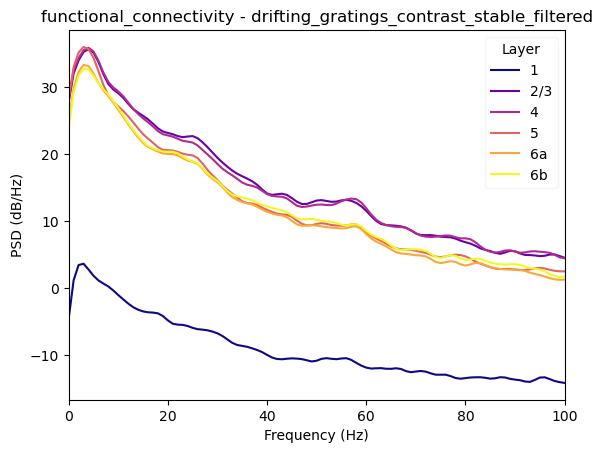

In [23]:
for session_type, psd_avg_ds in psd_avg.items():
    if SAVE_FIGURE:
        layer_psd_dir_ = layer_psd_dir / session_type
        layer_psd_dir_.mkdir(parents=True, exist_ok=True)

    for stim, da in psd_avg_ds.data_vars.items():
        ax = plots.plot_channel_psd(da, channel_dim='layer', freq_range=plt_range)
        ax.set_title(f"{session_type} - {stim}")

        if SAVE_FIGURE:
            fig = ax.get_figure()
            save_figure(layer_psd_dir_, fig, name=f"{session_type}-{stim}")

    plt.show()

In [24]:
if SAVE_FIGURE:
    for session_type, psd_avg_ds in psd_avg.items():
        fooof_dir_ = fooof_dir / session_type
        fooof_dir_.mkdir(parents=True, exist_ok=True)

        for stim in psd_avg_ds.data_vars.keys():
            figs = {}
            for layer in psd_avg_ds.coords['layer'].values:
                fig, ax = plt.subplots(1, 1)
                ax = plots.plot_fooof_quick(fooof_objs[session_type][stim][layer], freq_range=plt_range, ax=ax)

                band = avg_bands_ds[session_type].bands.sel(stimulus=stim, layer=layer)
                ax = plots.plot_freq_band(band, band.wave_band, ax=ax)
                ax.set_title(f"{stim} layer {layer}")

                figs[f"{stim}_layer_{format_for_path(layer)}"] = fig

            save_figure(fooof_dir_, figs)
            plt.close('all')